# Reconocer Temas base de una pregunta con BERT

[Hugging Face](https://huggingface.co/)


In [ ]:
!pip install transformers

In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,TFBertModel
import torch
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint



## Carga y limpieza de los datos



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Drive
TRAIN_DATASET_PATH = '/content/drive/MyDrive/ProyectoMineria/DatosEntrenamiento/train_com_adjusted_4.xlsx'
TEST_DATASET_PATH='/content/drive/MyDrive/ProyectoMineria/DatosEntrenamiento/test_com_adjusted_4.xlsx'
LABELS_DATA_PATH='/content/drive/MyDrive/ProyectoMineria/DatosEntrenamiento/label_adjusted_4.xlsx'

In [ ]:
# SE CARGAN LOS CSV EN DATA FRAMES
df_labels = pd.read_excel(LABELS_DATA_PATH)
df_train = pd.read_excel(TRAIN_DATASET_PATH)
df_test = pd.read_excel(TEST_DATASET_PATH)


In [ ]:
#FUNCION PARA CAMBIAR LA CLASE POR UN IDENTIFICADOR
def change_label_to_number(label_df):
    row = df_labels[df_labels['label'] == label_df]
    if not row.empty:
        return (row['id'].values[0]).astype(int)
    else:
        # Manejar el caso en el que no se encuentra la etiqueta
        return None  # o cualquier valor predeterminado que desees

In [ ]:
# función para aplicar a los 2 conjuntos de datos
def adjust_dataset(df):
    # Aplica la función al DataFrame
    df['label'] = df['basic_knowledge_1'].apply(lambda x: change_label_to_number(x))
    df.drop(['basic_knowledge_1', 'type'], axis=1, inplace=True)

    return df



In [ ]:
df_train_adjusted = adjust_dataset(df_train)
df_train_adjusted['question']=df_train_adjusted['question'].astype(str)
df_train_adjusted.head()

df_test_adjusted = adjust_dataset(df_test)
df_test_adjusted['question']=df_test_adjusted['question'].astype(str)
df_test_adjusted.head()

,question,label
0,Imagina que estás dibujando una escalera. ¿Cóm...,0
1,Encuentra tres ejemplos en tu hogar donde haya...,0
2,Observa una esquina de una hoja de papel. ¿Qué...,0
3,Dibuja un semicírculo y señala el ángulo forma...,0
4,Piensa en una situación cotidiana en la que pu...,0


## Creación del  Modelo con Bert

PRE_TRAINED_MODEL_NAME es el modelo de hugging face que usaremos 

In [ ]:
# TOKENIZACIÓN
#PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_NAME ='dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# lo que hace es covertir los textos a tokens para que la red de bert pueda entender las preguntas

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [ ]:
# Tokenizar los textos para poder entrenarlos con bert
max_len = 500  # 500 son los caracteres para soportar preguntas extensas
train_encodings = tokenizer(list(df_train_adjusted['question']), max_length=max_len, truncation=True, padding='max_length', return_tensors='tf')
test_encodings = tokenizer(list(df_test_adjusted['question']), max_length=max_len, truncation=True, padding='max_length', return_tensors='tf')

1er prototipo, con una sola capa sobre Bert(capa de salida) (modelo descartado para el final)

In [ ]:
class BERTQuestionsClassifier(tf.keras.Model):
    def __init__(self, n_classes):
        super(BERTQuestionsClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = layers.Dropout(0.3)
        self.linear = layers.Dense(n_classes, activation='softmax')

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooler_output = outputs.pooler_output
        drop_output = self.drop(pooler_output)
        output = self.linear(drop_output)

        return output




2do prototipo, con una capa oculta entre bert y la capa de salida

In [ ]:
#añadiendo capa oculta
class BERTQuestionsClassifier(tf.keras.Model):
    def __init__(self, n_classes, hidden_units=256, dropout_rate=0.3):
        super(BERTQuestionsClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.hidden_layer = layers.Dense(hidden_units, activation='relu')
        self.dropout2 = layers.Dropout(dropout_rate)
        self.linear = layers.Dense(n_classes, activation='softmax')

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooler_output = outputs.pooler_output

        # Aplicar dropout y capa oculta adicional
        drop_output1 = self.dropout1(pooler_output)
        hidden_output = self.hidden_layer(drop_output1)
        drop_output2 = self.dropout2(hidden_output)

        # Capa de salida lineal
        output = self.linear(drop_output2)

        return output

3er prototipo, con 3 capas ocultas sobre Bert antes de la capa de salida (modelo final y definitivo)

In [ ]:
#con 3 capas ocultas
class BERTQuestionsClassifier(tf.keras.Model):
    def __init__(self, n_classes, hidden_units=512, dropout_rate=0.3):
        super(BERTQuestionsClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.hidden_layer = layers.Dense(hidden_units, activation='relu')
        self.dropout2 = layers.Dropout(dropout_rate)
        self.hidden_layer2 = layers.Dense(hidden_units//2, activation='relu')  # Nueva capa oculta
        self.dropout3 = layers.Dropout(dropout_rate)
        self.hidden_layer3 = layers.Dense(hidden_units//2, activation='relu')  # Otra nueva capa oculta
        self.dropout4 = layers.Dropout(dropout_rate)
        self.linear = layers.Dense(n_classes, activation='softmax')

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooler_output = outputs.pooler_output

        # Aplicar dropout y capas ocultas adicionales
        drop_output1 = self.dropout1(pooler_output)
        hidden_output = self.hidden_layer(drop_output1)
        drop_output2 = self.dropout2(hidden_output)

        # Nuevas capas ocultas
        hidden_output2 = self.hidden_layer2(drop_output2)
        drop_output3 = self.dropout3(hidden_output2)
        hidden_output3 = self.hidden_layer3(drop_output3)
        drop_output4 = self.dropout4(hidden_output3)

        # Capa de salida lineal
        output = self.linear(drop_output4)

        return output

In [ ]:
# Crear instancia del modelo con el número de clases que debe clasificar
N_CLASSES = len(df_labels['label']) 
print(N_CLASSES)
model = BERTQuestionsClassifier(N_CLASSES)



41


Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=2e-5, weight_decay=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Configuración del conjunto de entrenamiento y prueba con tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), df_train_adjusted['label']))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), df_test_adjusted['label']))


Etapa de entrenamiento y pruebas del modelo

In [ ]:
EPOCHS = 20
history = model.fit(train_dataset.batch(8), epochs=EPOCHS, validation_data=test_dataset.batch(8))

Epoch 1/20
51/51 [==============================] - 133s 1s/step - loss: 3.4251 - accuracy: 0.0246 - val_loss: 3.2897 - val_accuracy: 0.0519
Epoch 2/20
51/51 [==============================] - 54s 1s/step - loss: 3.3726 - accuracy: 0.0344 - val_loss: 3.2637 - val_accuracy: 0.0667
Epoch 3/20
51/51 [==============================] - 58s 1s/step - loss: 3.3270 - accuracy: 0.0369 - val_loss: 3.2431 - val_accuracy: 0.1333
Epoch 4/20
51/51 [==============================] - 54s 1s/step - loss: 3.3074 - accuracy: 0.0418 - val_loss: 3.2102 - val_accuracy: 0.1556
Epoch 5/20
51/51 [==============================] - 54s 1s/step - loss: 3.3011 - accuracy: 0.0516 - val_loss: 3.1695 - val_accuracy: 0.2074
Epoch 6/20
51/51 [==============================] - 54s 1s/step - loss: 3.2655 - accuracy: 0.0639 - val_loss: 3.1301 - val_accuracy: 0.1926
Epoch 7/20
51/51 [==============================] - 54s 1s/step - loss: 3.2102 - accuracy: 0.0786 - val_loss: 3.0539 - val_accuracy: 0.2370
Epoch 8/20
51/51 [=

In [ ]:
EPOCHS = 5
history = model.fit(train_dataset.batch(8), epochs=EPOCHS, validation_data=test_dataset.batch(8))

Epoch 1/5
51/51 [==============================] - 55s 1s/step - loss: 1.0175 - accuracy: 0.7985 - val_loss: 1.1976 - val_accuracy: 0.6963
Epoch 2/5
51/51 [==============================] - 54s 1s/step - loss: 0.8757 - accuracy: 0.8256 - val_loss: 1.1968 - val_accuracy: 0.6889
Epoch 3/5
51/51 [==============================] - 53s 1s/step - loss: 0.7325 - accuracy: 0.8845 - val_loss: 1.3588 - val_accuracy: 0.6963
Epoch 4/5
51/51 [==============================] - 54s 1s/step - loss: 0.7286 - accuracy: 0.8722 - val_loss: 1.1703 - val_accuracy: 0.7185
Epoch 5/5
51/51 [==============================] - 54s 1s/step - loss: 0.5897 - accuracy: 0.9091 - val_loss: 1.2504 - val_accuracy: 0.6889


In [ ]:
EPOCHS = 5
history = model.fit(train_dataset.batch(8), epochs=EPOCHS, validation_data=test_dataset.batch(8))

Epoch 1/5
93/93 [==============================] - 98s 1s/step - loss: 0.8543 - accuracy: 0.7908 - val_loss: 0.6937 - val_accuracy: 0.7925
Epoch 2/5
93/93 [==============================] - 98s 1s/step - loss: 0.7982 - accuracy: 0.8097 - val_loss: 0.7318 - val_accuracy: 0.7842
Epoch 3/5
93/93 [==============================] - 98s 1s/step - loss: 0.7125 - accuracy: 0.8381 - val_loss: 0.6855 - val_accuracy: 0.8050
Epoch 4/5
93/93 [==============================] - 98s 1s/step - loss: 0.6021 - accuracy: 0.8610 - val_loss: 0.6907 - val_accuracy: 0.7801
Epoch 5/5
93/93 [==============================] - 98s 1s/step - loss: 0.5665 - accuracy: 0.8516 - val_loss: 0.6735 - val_accuracy: 0.8174


## 81% de precisión  de los datos de validación !!!!

se almacena el modelo


In [ ]:
import os

# Especifica el directorio donde deseas guardar el modelo
output_dir = '/content/drive/MyDrive/ProyectoMineria/red_neuronal/6to'

# Crea el directorio si no existe
os.makedirs(output_dir, exist_ok=True)

# Guarda el modelo y el tokenizer en el directorio especificado
model.save(output_dir)

# Puedes guardar también el tokenizer si lo deseas
tokenizer.save_pretrained(output_dir)



('/content/drive/MyDrive/ProyectoMineria/red_neuronal/6to/tokenizer_config.json',
 '/content/drive/MyDrive/ProyectoMineria/red_neuronal/6to/special_tokens_map.json',
 '/content/drive/MyDrive/ProyectoMineria/red_neuronal/6to/vocab.txt',
 '/content/drive/MyDrive/ProyectoMineria/red_neuronal/6to/added_tokens.json')

Matriz de confución sobre los datos de validación

17/17 [==============================] - 6s 334ms/step


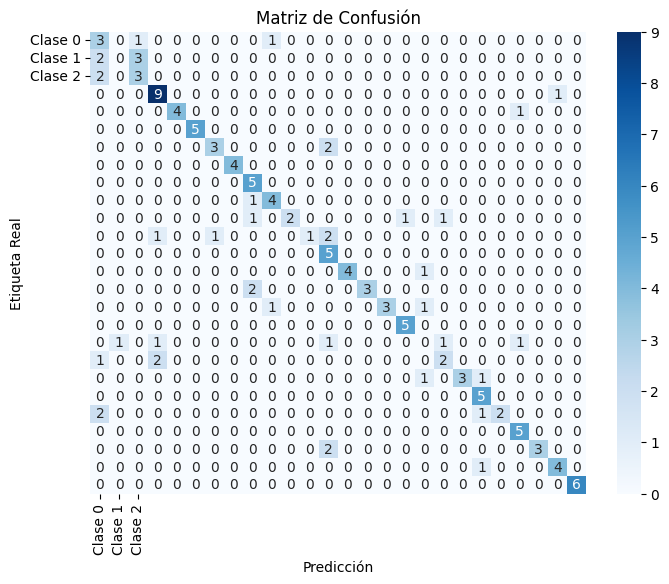

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Obtener las predicciones en el conjunto de prueba
test_predictions = model.predict(test_dataset.batch(8))

# Convertir las predicciones a clases (usando argmax)
predicted_classes = np.argmax(test_predictions, axis=1)

# Obtener las etiquetas reales
true_classes = np.concatenate([y.numpy() for x, y in test_dataset.batch(8)])

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Clase 0', 'Clase 1', 'Clase 2'], yticklabels=['Clase 0', 'Clase 1', 'Clase 2'])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Imprimir el reporte de clasificación
print(classification_report(true_classes, predicted_classes))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         2
           2       0.56      0.56      0.56         9
           3       0.88      1.00      0.93         7
           4       1.00      1.00      1.00         3
           5       0.50      0.25      0.33         4
           6       1.00      0.80      0.89         5
           7       1.00      0.43      0.60         7
           8       0.75      0.75      0.75         4
           9       0.60      0.75      0.67         4
          10       1.00      0.62      0.77         8
          11       0.80      0.80      0.80         5
          12       1.00      0.50      0.67         4
          14       0.43      0.38      0.40         8
          15       0.33      0.33      0.33         3
          16       0.60      1.00      0.75         3
          17       0.25      0.50      0.33         2
          18       0.42    

Código para hacer pruebas de predicción

In [ ]:
def change_number_to_label(prediction):
    for label in df_labels:
        if int(label[1]) == int(prediction):
            return label['label']

In [ ]:
def predecir_etiqueta(modelo, tokenizador, pregunta, max_len=500):
    # Tokeniza la pregunta
    encoding = tokenizador(
        [pregunta],
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

    # Realiza la predicción con el modelo
    predicciones = modelo.predict({
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask']
    })

    # Aplica softmax para obtener probabilidades
    probabilidades = tf.nn.softmax(predicciones, axis=-1)

    # Obtiene la etiqueta predicha como el índice de la clase con mayor probabilidad
    etiqueta_predicha = tf.argmax(probabilidades, axis=-1).numpy()[0]

    return change_number_to_label(etiqueta_predicha)





In [ ]:
pregunta_nueva = "Imagina que estás construyendo una ciudad con polígonos. Calcula el perímetro total de la ciudad sumando los perímetros de los diferentes polígonos que la componen."
etiqueta_predicha = predecir_etiqueta(model, tokenizer, pregunta_nueva)
print(f"Para la pregunta: {pregunta_nueva}")
print(f"la etiqueta predicha es: {(etiqueta_predicha)}")

1/1 [==============================] - 4s 4s/step
Para la pregunta: Imagina que estás construyendo una ciudad con polígonos. Calcula el perímetro total de la ciudad sumando los perímetros de los diferentes polígonos que la componen.
la etiqueta predicha es: Polígonos regulares e irregulares
